
In order to run this notebook locally you will need
- a local instsallation of feltor: follow the quick-start guide https://github.com/feltor-dev/feltor (we do need jsoncpp and netcdf, but not glfw, and a link to path/to/feltor/inc/dg in home/include)
- a local installation of simplesimdb: follow the quick-start guide https://github.com/mwiesenberger/simplesimdb
- to compile the cpp codes in this repository: type make in a shell

### Plasma two-fluid equations

As a next step we investigate the two-fluid equations (also known as two-fluid Euler-Poisson system)
 \begin{align}
     \frac{\partial }{\partial t} n_e&= - \frac{\partial}{\partial x} (u_en_e )  + S_{n} \\
     \frac{\partial }{\partial t} n_i&= - \frac{\partial}{\partial x} (u_in_i )  + S_{n} \\   
    \frac{\partial }{\partial t} n_eu_e&= - \frac{\partial}{\partial x} n_eu_e^2 - \frac{\tau_e}{\mu_e}\frac{\partial}{\partial x} n_e - \frac{1}{\mu_e} n_e\frac{\partial}{\partial x} \phi - \frac{\eta}{\mu_e} n_i (n_i u_i - n_e u_e) + \nu_{u,e}\frac{\partial^2}{\partial x^2} u_e\\
     \frac{\partial }{\partial t} n_iu_i&= - \frac{\partial}{\partial x} n_iu_i^2 - \frac{\tau_i}{\mu_i}\frac{\partial}{\partial x} n_i - \frac{1}{\mu_i}n_i\frac{\partial}{\partial x} \phi - \frac{\eta}{\mu_i} n_i (n_i u_i - n_e u_e) + \nu_{u,i}\frac{\partial^2}{\partial x^2} u_i
 \end{align}
 which is closed by the one-dimensional Poisson equation
 \begin{align}
 -\frac{\partial^2}{\partial x^2} \phi = \frac{n_i - n_e}{\epsilon_D}
 \end{align}
 
 where we have Gyro-Bohm normalization and $\mu_e = -m_e/m_i$, $\mu_i = 1$, $\tau_e = -1$ and $\tau_i = T_i / T_e$. Further, 
 we have $\eta = 0.51 \nu_{ei,0}/ \Omega_{ce}$ and $\nu_{u,e} = 0.73
 \Omega_{ce} / \nu_{ei,0}$ and $\nu_{u,i} = 0.96 \Omega_{ci} / \nu_{ii,0}$. Last, we have the Debye parameter $\epsilon_D = \lambda_D^2 / \rho_s^2$ with the Debye length $\lambda_D$ and the
 ion gyro-radius at electron temperature $\rho_s$. Note that we choose the peculiar signs in $\mu_e$ and $\tau_e$ such that the electron and ion momentum equations have exactly the same form, which makes it easy to implement.
 
 Also note that we choose Bohm normalization based on gyro-radius $\rho_s$ and gyro-frequency $\Omega_{ci}$  because this is how we normalize the three-dimensional model. However, there is no magnetic field in the model and so the gyration does not appear. The more natural normalisation uses plasma frequency and Debye length, which makes the $\epsilon_D$ parameter disappear {cite}`Sack1987`. 
 
 The spatial domain is given by
$[-L_\parallel /2 ; L_\parallel/2]$, where $L_\parallel = 2\pi q R_0$ with $q=3$ and $R_0=0.545$m approximating the length of a fieldline from divertor to divertor in the Compass SOL. We use $N_x$ points.
 
 #### Neutral fluid limit
 We reach the limit of Navier Stokes fluid equations by first setting
 $\mu_e = 0$. Then we find from the electron momentum equation $-\tau_e \partial_x n_e - n_e\partial_x \phi - \eta n_e j = 0$, which
yields the force term $-\tau_i \partial_x n_i + \tau_e \partial_x n_i + \tau_e \epsilon_D \partial_x^3 \phi + \epsilon_D \partial_x (\partial_x \phi)^2 / 2 $ in the ion momentum equation. In the limit $\epsilon_D=0$ the
ion continuity and ion momentum equations thus decouple from the system and yield the Navier Stokes equations.

#### Adiabatic electrons
In the limit of $\mu_e=0$ and vanishing resistivity $\eta =0$
the electron force balance reduces to $\partial_x n_e = n_e \partial_x\phi$ which is solved by $n_e = n_{e,0}\exp(\phi)$. 
 \begin{align}
     \frac{\partial }{\partial t} n_i&= - \frac{\partial}{\partial x} (u_in_i ) + S_{n} \\   
     \frac{\partial }{\partial t} n_iu_i&= - \frac{\partial}{\partial x} n_iu_i^2 - \tau_i\frac{\partial}{\partial x} n_i - n_i\frac{\partial}{\partial x} \phi + \nu_{u,i}\frac{\partial^2}{\partial x^2} u_i
 \end{align}
 which is closed by the one-dimensional non-linear Poisson   equation (choosing $n_{e,0}=1$)
 \begin{align}
 -\frac{\partial^2}{\partial x^2} \phi = \frac{n_i - \exp(\phi)}{\epsilon_D}
 \end{align}

In [1]:
import numpy as np
import json
import simplesimdb as simplesim
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from numpy.fft import fft, fftfreq, rfft


In [2]:
# feltorutilities is still a private repository under development
# Ask Matthias mattwi@fysik.dtu.dk to get access!
#import feltorutilities as fp
# These parameters are for a Tokamak

table = {"name" : "Compass",
    "beta" : 1e-4, "resistivity": 1e-4, #change both to change n_0
   "tau" : 1.,
   "m_i" : 1., "R_0" : 545, "R": 0.545,
   "a": 0.175, "q":2, "scaleR" : 1.45, "Nz" : 32,
    "mu" : -0.00027244371074816386, "epsilon_D" : 4.1458919332419e-05, "viscosity_e" : 3700.000000592561,
         "viscosity_i" : 113.89049597255578,
        "lx" : 10273.}


In [3]:
# The code plasma.cpp discretizes the above equations
# in space and time with various schemes.
# In the following we document the possible input parameters:
def make_plasma_input(physical) :
    # PARAM: physical: dict with entries: "lx", "mu", "epsilon_D",
    # "viscosity_e", "viscosity_i", "resistivity", "tau"
    return {
    "grid" : {
        "Nx" : 32,
        # number of grid points
        "x" : [-table["lx"]/2, table["lx"]/2],
        # spatial domain [x_0,x_1]
    },
     "init":
     {
         # A sine wave in density with 0 velocity
         "type" : "wave",
         "amp" : 0.5,
         "n_0" : 1,
         "k" : 4*np.pi,
         "x_0" : 0
     },
     "init":
     {
         "type" : "step", # a step in density, 0 velocity
         "x_a" : 0.5, # location of jump
         "n_l" : 1,   # density left of jump
         "n_r" : 0.2, # density right of jump
     },
    "init":
    {
        "type" : "soft-step",
        "x_a" : 0., # location of jump (in units of lx)
        "alpha" : 0.1, # transition width (in units of lx)
        # [x_a - alpha/2, x_a+alpha/2]
        "n_l" : 1,   # density left of jump
        "n_r" : 0.2, # density right of jump
    },
#     "init":
#     {
#          # Manufactured solution without shock
#         "type" : "mms",
#         "n_0" : 1,
#         "u_0" : 0.5,
#         "A" : 0.2,
#         "B" : 0.1,
#         "k" : 4*np.pi,
#         "v" : 1
#     },
    "advection" : 
    {
        "type" : "staggered", 
        # centered
        # staggered (allows variant)
        "variant" : "original"
        # original (The original scheme, 1st order)
        # explicit (Take force terms explicitly)
        # slope-limiter (Use 2nd order flux)
        # slope-limiter-explicit (Use 2nd order flux
        #     and force terms explicit)
    },
    "timestepper":
    {
        # The Additive Runge Kutta (ARK) method is a semi-implicit
        # embedded Runge Kutta scheme that works for all (explicit
        # and implicit) advection schemes above
        "type" : "ARK",
        "tableau" : "ARK-4-2-3",
        "rtol" : 1e-6, # relative tolerance
        "atol" : 1e-7  # absolute tolerance
        # The Embedded Runge Kutta (ERK) only works 
        # for explicit schemes
        # "type" : "ERK", 
        # "tableau" : "Bogacki-Shampine-4-2-3"
    },
    "physical":
    {
        "type" : "original", # plasma two-fluid equations
        # "type" : "adiabatic", # adiabatic electrons 
        # n_e and u_e are 0 in output file
        "nu_u" : [table["viscosity_e"], table["viscosity_i"]],
        # viscosity for [electrons, ions]
        "nu_n" : [0.0, 0.0], 
        # diffusivity for [electron, ions]
        # (can be used to stabilize)
        "resistivity" : table["resistivity"],
        # plasma resistivity eta
        "mu" : table["mu"],
        # negative electron to ion mass ratio
        "tau" : table["tau"],
        # ion to electron temperature ratio
        "epsilon_D" : table["epsilon_D"]
    },
    # },physical={"name" : "Compass",
#    "beta" : 1e-4, "resistivity": 1e-4, #change both to change n_0
#   "tau" : 1,
#   "m_i" : fp.deuteron_mass, "R_0" : 545, "R": 0.545,
#   "a": 0.175, "q":2, "scaleR" : 1.45, "Nz" : 32}
                
    "bc" :
    {
         # one of PER, NEU, DIR, DIR_NEU, NEU_DIR
        "density": "NEU",
        "velocity" : "NEU",
        "potential" : "DIR_NEU"
    },
    "poisson":
    {
#         "type" : "anderson", # most general non-linear solver
        "type" : "gmres",
#         "type" : "cg", # if it works it is the fastest method
#         "type" :"bicgstab",
#         # parameters for iterative solvers
        "max_inner" : 30, # 30 is a good number
        "max_outer" : 3, # 3-10
        "l_input" : 3, # 2-4 is a good number
        "mMax" : 10, # 3 - 10 is a good number
        "damping" : 1e-2, # 0.1 to 1e-3 is a good start
        
        "eps" : 1e-6, # accuracy          
    },
    "output":
    {
        # The simulation will run from t = 0 to t = t_end
        "tend" : 0.001, # end time
        # Choose a number of (equidistant in time) outputs
        # in output file (excluding first)
        "maxout" : 20 
    }
    }

In [4]:
# This works completely analogous to the continuity case above
rep = simplesim.Repeater("./plasma","temp.json", "temp.nc")
rep.clean()
rep.run( make_plasma_input(table), error="display", stdout="ignore")
ncin = Dataset( "temp.nc", 'r', format="NETCDF4")
print( "FILE CONTENTS")
for v in ncin.variables:
    if v == "time" : 
        print(f"{v} {ncin.variables[v].shape}")
    else : 
        print( f"{v} {ncin.variables[v].shape}",
            f"\t{ ncin.variables[v].long_name}")

ncin.close()

FILE CONTENTS
time (21,)
x (32,) 	x-coordinate in Computational coordinate system
failed (21,) 	Accumulated Number of failed steps
duration (21,) 	Computation time for the latest output
nsteps (21,) 	Accumulated Number of calls to the RHS functor (including failed steps)
electrons (21, 32) 	Numerical electron density
ions (21, 32) 	Numerical electron density
ue (21, 32) 	Numerical electron velocity
ui (21, 32) 	Numerical ion velocity
potential (21, 32) 	potential
electrons_ana (21, 32) 	Analytical solution to the electron density
ions_ana (21, 32) 	Analytical solution to the ion density
ue_ana (21, 32) 	Analytical solution to the electron velocity
ui_ana (21, 32) 	Analytical solution to the ion velocity
potential_ana (21, 32) 	Analytical solution to the potential


In [5]:
# Again, we define a plotting routine that loops over
# parameters sets, runs simulations and plots the results
def plot_plasma( p_list):
    
    plt.rcParams.update({'font.size': 20})
    frows = 3
    fcols = 2

    fig,ax=plt.subplots(frows,fcols,figsize=(fcols*10,frows*8),dpi= 80, facecolor='w', edgecolor='k')
    #https://matplotlib.org/stable/tutorials/colors/colormaps.html

    plotted = False
    for p in p_list :
        rep.clean()
        rep.run( p, error="display", stdout="ignore")
        ncin = Dataset( "temp.nc", 'r', format="NETCDF4")
        var = ncin.variables
        time = var["time"][:]
        last_idx  = time.shape[0]-1
        nsteps = var["nsteps"][last_idx]
        failed = var["failed"][last_idx]
        error = var["electrons"][:,:] - var["electrons_ana"][:,:]
        norm_ana = np.linalg.norm( var["electrons_ana"][last_idx,:], ord=1)
        #norm_ana = np.size( error[last_idx,:])


        x = var["x"][:]

        if not plotted and not norm_ana == 0:
            im = ax[0][0].plot(x, var["electrons_ana"][last_idx,:],
                            color='k', label="analytical", lw=4)
            im = ax[0][1].plot(x, var["ions_ana"][last_idx,:],
                            color='k', label="analytical", lw=4)
            plotted = True
        l = f"{p['output']['tend']}" #labels set to endtime
        #if( "variant" in p["advection"].keys() ):
        #    l = l + f" {p['advection']['variant']}"
        
        print(l)
        if not norm_ana == 0:
            print( f"L2 Error norm is {np.linalg.norm(error[last_idx,:], ord=1)/norm_ana:.2e}",end=" ")
        print( f"Function Calls is {nsteps} Failed {failed}")
        electrons = var["electrons"][last_idx,:]
        if p["physical"]["type"] == "adiabatic" :
            electrons = np.exp( var["potential"][last_idx ,:])
        im = ax[0][0].plot(x,electrons, label=l, lw=4)
        im = ax[0][1].plot(x,var["ions"][last_idx,:]-electrons, label=l, lw=4)
        im = ax[1][0].plot( x, var["ue"][last_idx,:], lw=4)
        im = ax[1][1].plot( x, var["ui"][last_idx,:], lw=4)
        potential = var["potential"][last_idx,:]
        im = ax[2][0].plot( x, potential, lw=4)
        electric = -np.gradient( potential, x)
        im = ax[2][1].plot( x, electric, lw=4)
        ncin.close()
    ax[0][0].set_title( f"electron density") # Nx = {p['grid']['Nx']}") #t = {time[last_idx]:8.4f}
    ax[0][0].set_xlabel( r"s [$\rho_s$]")
    ax[0][0].set_ylabel("n")
    ax[0][0].legend()
    
    ax[0][1].set_title( f"charge density")
    ax[0][1].set_xlabel( r"s [$\rho_s$]")
    ax[0][1].set_ylabel("u")
    
    ax[1][0].set_title( f"electron velocity")
    ax[1][0].set_xlabel( r"s [$\rho_s$]")
    ax[1][0].set_ylabel( r"$u_e$")

    ax[1][1].set_title( f"ion velocity")
    ax[1][1].set_xlabel( r"s [$\rho_s$]")
    ax[1][1].set_ylabel( r"$u_i$")   
    
    ax[2][0].set_title( f"potential")
    ax[2][0].set_xlabel( r"s [$\rho_s$]")
    ax[2][0].set_ylabel( r"$\phi$")
    
    ax[2][1].set_title( f"electric field")
    ax[2][1].set_xlabel( r"s [$\rho_s$]")
    ax[2][1].set_ylabel( r"$E$")   
    

First, we simulate the full plasma two-fluid system.

{'grid': {'Nx': 1000, 'x': [-5136.5, 5136.5]}, 'init': {'type': 'soft-step', 'x_a': 0.0, 'alpha': 0.4, 'n_l': 1, 'n_r': 0.01}, 'advection': {'type': 'staggered', 'variant': 'original'}, 'timestepper': {'type': 'ARK', 'tableau': 'ARK-4-2-3', 'rtol': 1e-05, 'atol': 1e-07}, 'physical': {'type': 'original', 'nu_u': [0.0, 0.0], 'nu_n': [0.0, 0.0], 'resistivity': 0.0001, 'mu': -0.00027244371074816386, 'tau': 1.0, 'epsilon_D': 4.1458919332419e-05}, 'bc': {'density': 'NEU', 'velocity': 'NEU', 'potential': 'DIR_NEU'}, 'poisson': {'type': 'bicgstab', 'max_inner': 30, 'max_outer': 3, 'l_input': 3, 'mMax': 10, 'damping': 0.01, 'eps': 1e-12}, 'output': {'tend': 0, 'maxout': 20}}
{'grid': {'Nx': 1000, 'x': [-5136.5, 5136.5]}, 'init': {'type': 'soft-step', 'x_a': 0.0, 'alpha': 0.4, 'n_l': 1, 'n_r': 0.01}, 'advection': {'type': 'staggered', 'variant': 'original'}, 'timestepper': {'type': 'ARK', 'tableau': 'ARK-4-2-3', 'rtol': 1e-05, 'atol': 1e-07}, 'physical': {'type': 'original', 'nu_u': [0.0, 0.0], 

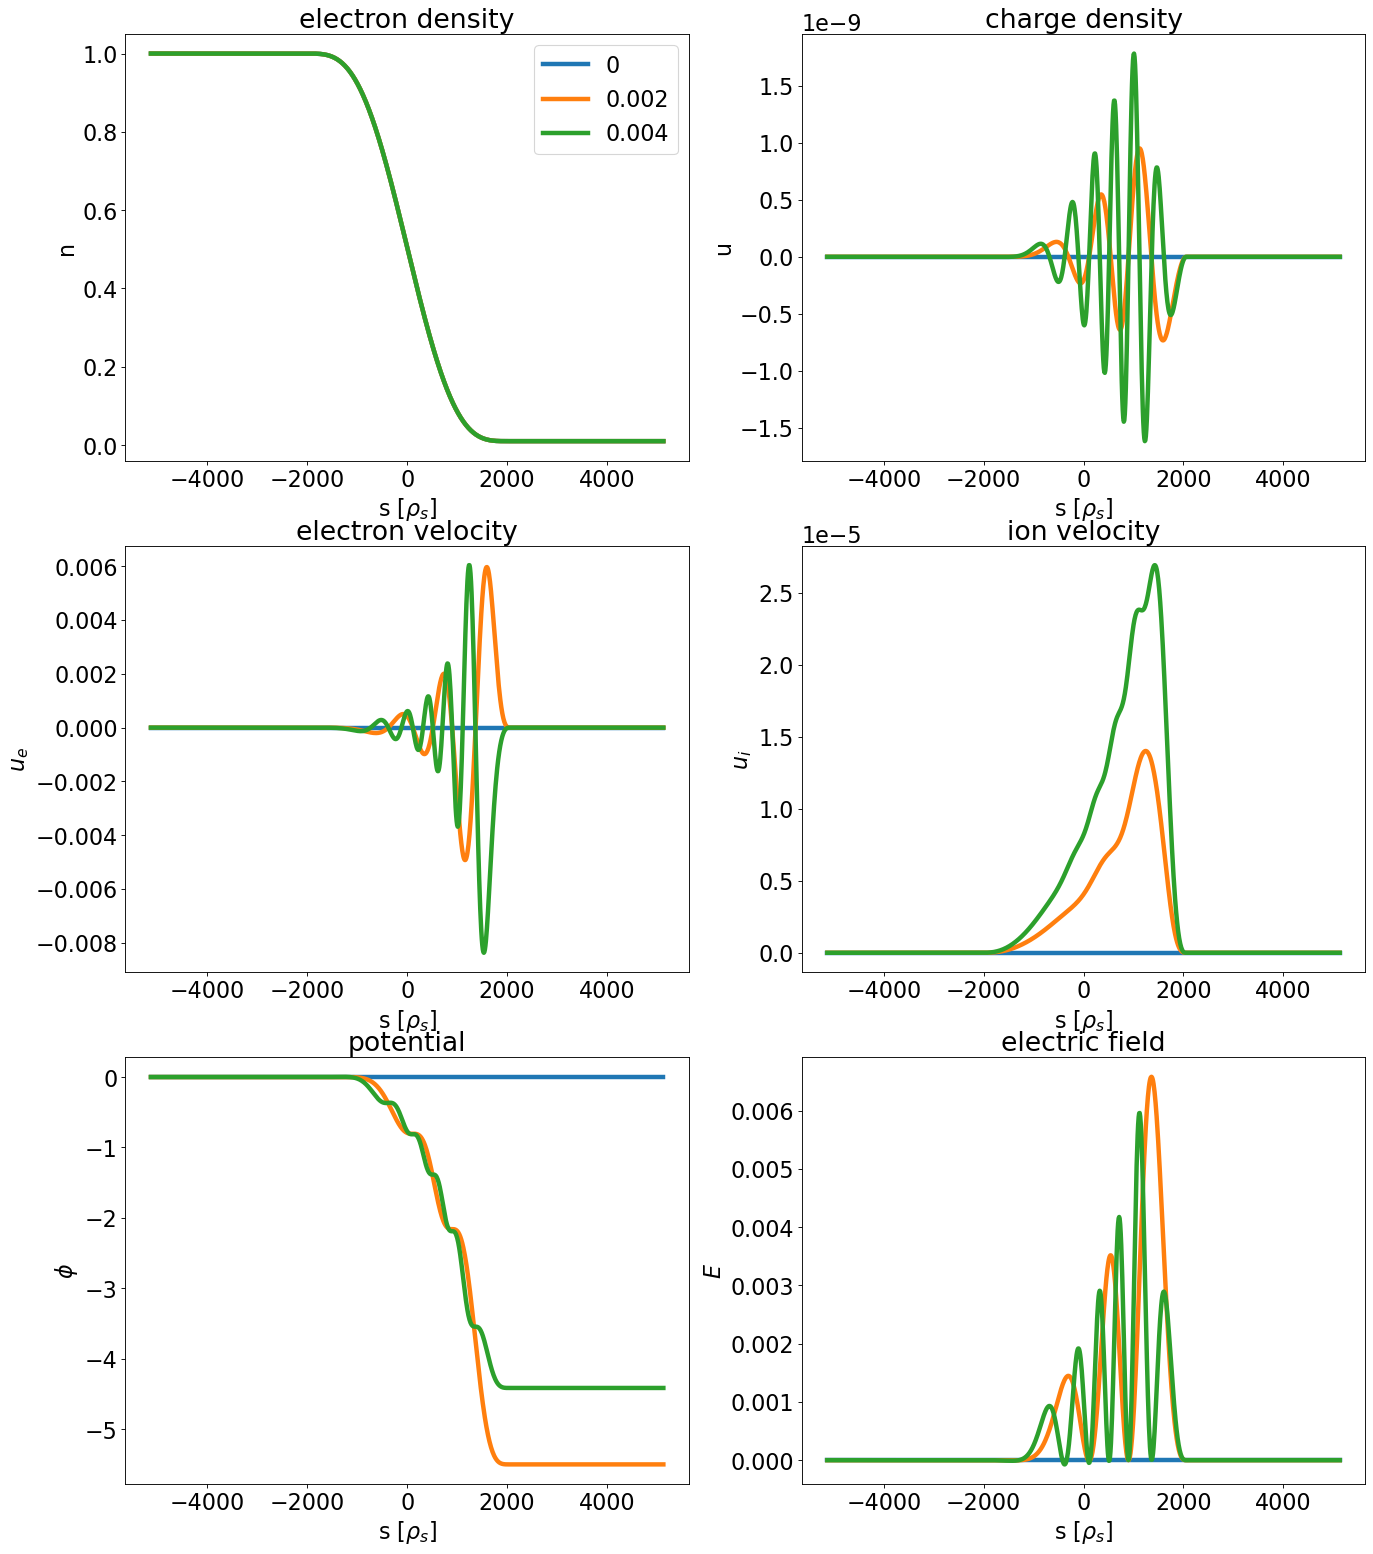

In [6]:
p_list = []
indextime=0
ncin = Dataset( "temp.nc", 'r', format="NETCDF4")
var = ncin.variables
time = var["time"][:]
last_idx  = time.shape[0]-1
electrons = var["electrons"][last_idx,:]
for p in [
    
    #using the staggered scheme only
   {"type" : "staggered", "variant" : "original"},
     {"type" : "staggered", "variant" : "original"},
       {"type" : "staggered", "variant" : "original"}
  
#     {"type" : "centered"},
         ] :
    params = make_plasma_input(table)
    
    #simulating the non-adiabatic case, with no viscosities, resistivity = 0.0001, epsilon_D = 1, mu = 1
    #using step as IC
    params = make_plasma_input(table)
    params["init"]["alpha"] = 0.4
    params["init"]["n_r"] = 0.01
    params["grid"]["Nx"]= 1000
    params["output"]["tend"] =indextime #1e-4 to 1e-2
    params["timestepper"]["type"] = "ARK"
    params["timestepper"]["tableau"]  = "ARK-4-2-3"
    params["poisson"]["eps"]= 1e-12
    params["poisson"]["type"] = "bicgstab"
    params["physical"]["nu_u"] = [0.,0.]
    params["physical"]["tau"] = 1.0
    params["physical"]["type"] = "original"
    params["advection"] = p
    params["timestepper"]["rtol"] = 1e-5
    
    p_list.append(params)
    print(params)
    indextime=indextime+2e-3
plot_plasma(p_list)


We observe
- steps in the potential
- oscillations in the electron velocity and electric field indicating rapid plasma oscillations

428.04166666666663
9.998691509337432e-08


/tmp/ipykernel_4560/3780352139.py:40: RuntimeWarning: divide by zero encountered in true_divide
  ax = plt.plot(2*np.pi/kscaled, fft_calc, color = 'k',


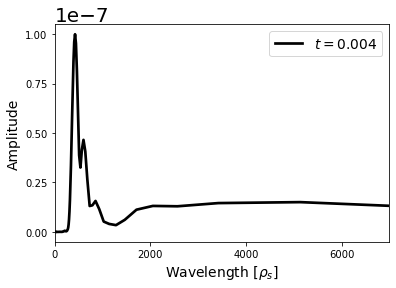

/tmp/ipykernel_4560/3780352139.py:70: RuntimeWarning: divide by zero encountered in true_divide
  ax = plt.plot(2*np.pi/kscaled, fft_calc, color = colorlist[coloridx],
/tmp/ipykernel_4560/3780352139.py:70: RuntimeWarning: divide by zero encountered in true_divide
  ax = plt.plot(2*np.pi/kscaled, fft_calc, color = colorlist[coloridx],
/tmp/ipykernel_4560/3780352139.py:70: RuntimeWarning: divide by zero encountered in true_divide
  ax = plt.plot(2*np.pi/kscaled, fft_calc, color = colorlist[coloridx],
/tmp/ipykernel_4560/3780352139.py:70: RuntimeWarning: divide by zero encountered in true_divide
  ax = plt.plot(2*np.pi/kscaled, fft_calc, color = colorlist[coloridx],
/tmp/ipykernel_4560/3780352139.py:70: RuntimeWarning: divide by zero encountered in true_divide
  ax = plt.plot(2*np.pi/kscaled, fft_calc, color = colorlist[coloridx],


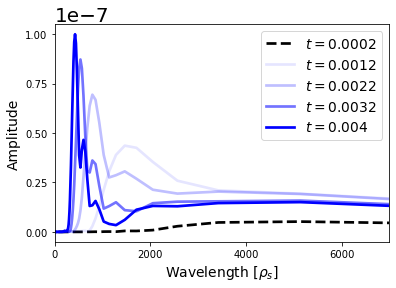

In [7]:
ncin = Dataset( "temp.nc", 'r', format="NETCDF4")
p = json.loads(ncin.inputfile)

lx = p['grid']['x'][1]-p['grid']['x'][0]
Nx = p['grid']['Nx']

var = ncin.variables
time = var["time"][:]

idx=20
electrons = var["electrons"][idx,:]

rho = var["ions"][idx,:]-electrons

fft_calc=np.abs(np.fft.rfft(rho))
#N = Nx/2+1


k=np.linspace(0,500,501)
kscaled=k*2*np.pi/lx


maxIndex = fft_calc.argmax(axis=0)

#print peak wave length and amplitude of peak of FFT of charge density 
#at t=0.004.
print (2*np.pi/kscaled[maxIndex])
print (fft_calc[maxIndex])

#Create FFT plot
for p in [10]:
    electrons = var["electrons"][idx,:]
    #print("Time", time[idx])
    rho = var["ions"][idx,:]-electrons
    
    fft_calc=np.abs(np.fft.rfft(rho))
    
    labeltime=round(idx/20*0.004,5)
    
    ax = plt.plot(2*np.pi/kscaled, fft_calc, color = 'k', 
             linestyle ='solid', linewidth = 2.7, label=r"$t={}$".format(labeltime))
    plt.xlabel("Wavelength [" r"$\rho_s$" "]", fontsize='x-small')
    plt.ylabel("Amplitude", fontsize='x-small')  
    
    plt.xlim([0, 7000])
  
plt.legend(fontsize='x-small')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


#Create FFT plot with different endtimes
idx=1
coloridx=0
colorlist=['0',(0.0, 0.0, 1.0, 0.1),(0.0, 0.0, 1.0, 0.25),(0.0, 0.0,1.0, 0.55),(0.0, 0.0, 1.0, 1.0)]
linestyleidx=0
linestylelist=['dashed','solid','solid','solid','solid']
#print(linestylelist)

for p in [10, 20, 30, 40,50]:
    electrons = var["electrons"][idx,:]
    #print("Time", time[idx])
    n = var["ions"][idx,:]-electrons

    fft_calc=np.abs(np.fft.rfft(n))
    
    labeltime=round(idx/20*0.004,5)
    
    ax = plt.plot(2*np.pi/kscaled, fft_calc, color = colorlist[coloridx], 
             linestyle =linestylelist[linestyleidx], linewidth = 2.7, label=r"$t={}$".format(labeltime))
    plt.xlabel("Wavelength [" r"$\rho_s$" "]", fontsize='x-small')
    plt.ylabel("Amplitude", fontsize='x-small')
    
    idx=idx+5
    if idx==21:
        idx=20
        
    coloridx=coloridx+1
    linestyleidx=linestyleidx+1
    plt.xlim([0, 7000])
  
plt.legend(fontsize='x-small')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


[0.     0.0002 0.0004 0.0006 0.0008 0.001  0.0012 0.0014 0.0016 0.0018
 0.002  0.0022 0.0024 0.0026 0.0028 0.003  0.0032 0.0034 0.0036 0.0038
 0.004 ]


/tmp/ipykernel_4560/2584690218.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  peaks[x]=2*np.pi/kscaled[maxIndex]


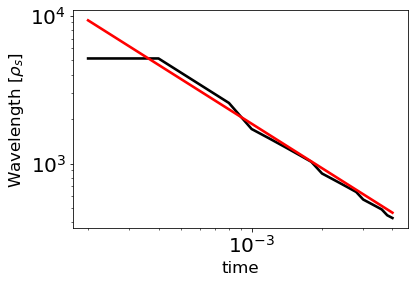

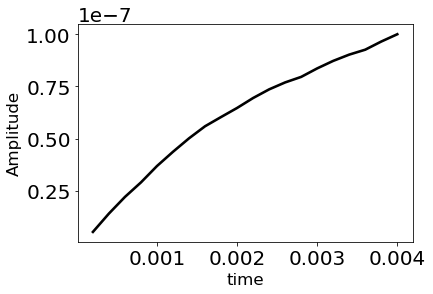

In [8]:

#plot wavelength of peak of FFT of charge density as function of endtime.
times = var['time'][:]
peaks=np.zeros(np.size(times))

print(times)
for x in range(np.size(times)):
    electrons = var["electrons"][x,:]
    
    n = var["ions"][x,:]-electrons
    
    fft_calc=np.abs(np.fft.rfft(n))
    maxIndex = fft_calc.argmax(axis=0)
    
    peaks[x]=2*np.pi/kscaled[maxIndex]
    
    
plt.plot(times[1:], peaks[1:],color = '0', linewidth = 2.6) 
plt.plot(times[1:], 1.86*times[1:]**(-1),color = 'r', linewidth = 2.6) 
plt.xlabel("time", fontsize='small')
plt.ylabel("Wavelength [" r"$\rho_s$" "]", fontsize='small')
plt.yscale('log')
plt.xscale('log')

plt.show()

#plotting peak amplitude as function of endtime.
peaksamplitude=np.linspace(0,20,20)

for x in range(20):
    electrons = var["electrons"][x+1,:]
    n = var["ions"][x+1,:]-electrons
    
    fft_calc=np.abs(np.fft.rfft(n))
    maxIndex = fft_calc.argmax(axis=0)
    #print (2*np.pi/kscaled[maxIndex])
    #print (fft_calc[maxIndex])
    #print(x)
    peaksamplitude[x]=fft_calc[maxIndex]
    
    
plt.plot(np.linspace(1,20,20)/20*0.004, peaksamplitude, color = '0', linewidth = 2.6) 


plt.xlabel("time", fontsize='small')
plt.ylabel("Amplitude", fontsize='small')

plt.show()



0.001
Function Calls is 10720.0 Failed 1038.0
{'grid': {'Nx': 1600, 'x': [-2, 2]}, 'init': {'type': 'soft-step', 'x_a': 0, 'alpha': 0.1, 'n_l': 1e+19, 'n_r': 1e+17}, 'advection': {'type': 'staggered', 'variant': 'original'}, 'timestepper': {'type': 'ARK', 'tableau': 'ARK-4-2-3', 'rtol': 1e-05, 'atol': 1e-07}, 'physical': {'type': 'adiabatic', 'nu_u': [0.0, 0.0], 'nu_n': [0.0, 0.0], 'resistivity': 0.0, 'mu': -1, 'tau': 1.0, 'epsilon_D': 4.1458919332419e-05}, 'bc': {'density': 'NEU', 'velocity': 'NEU', 'potential': 'DIR_NEU'}, 'poisson': {'type': 'anderson', 'max_inner': 30, 'max_outer': 3, 'l_input': 3, 'mMax': 10, 'damping': 0.01, 'eps': 1e-12}, 'output': {'tend': 0.001, 'maxout': 20}}


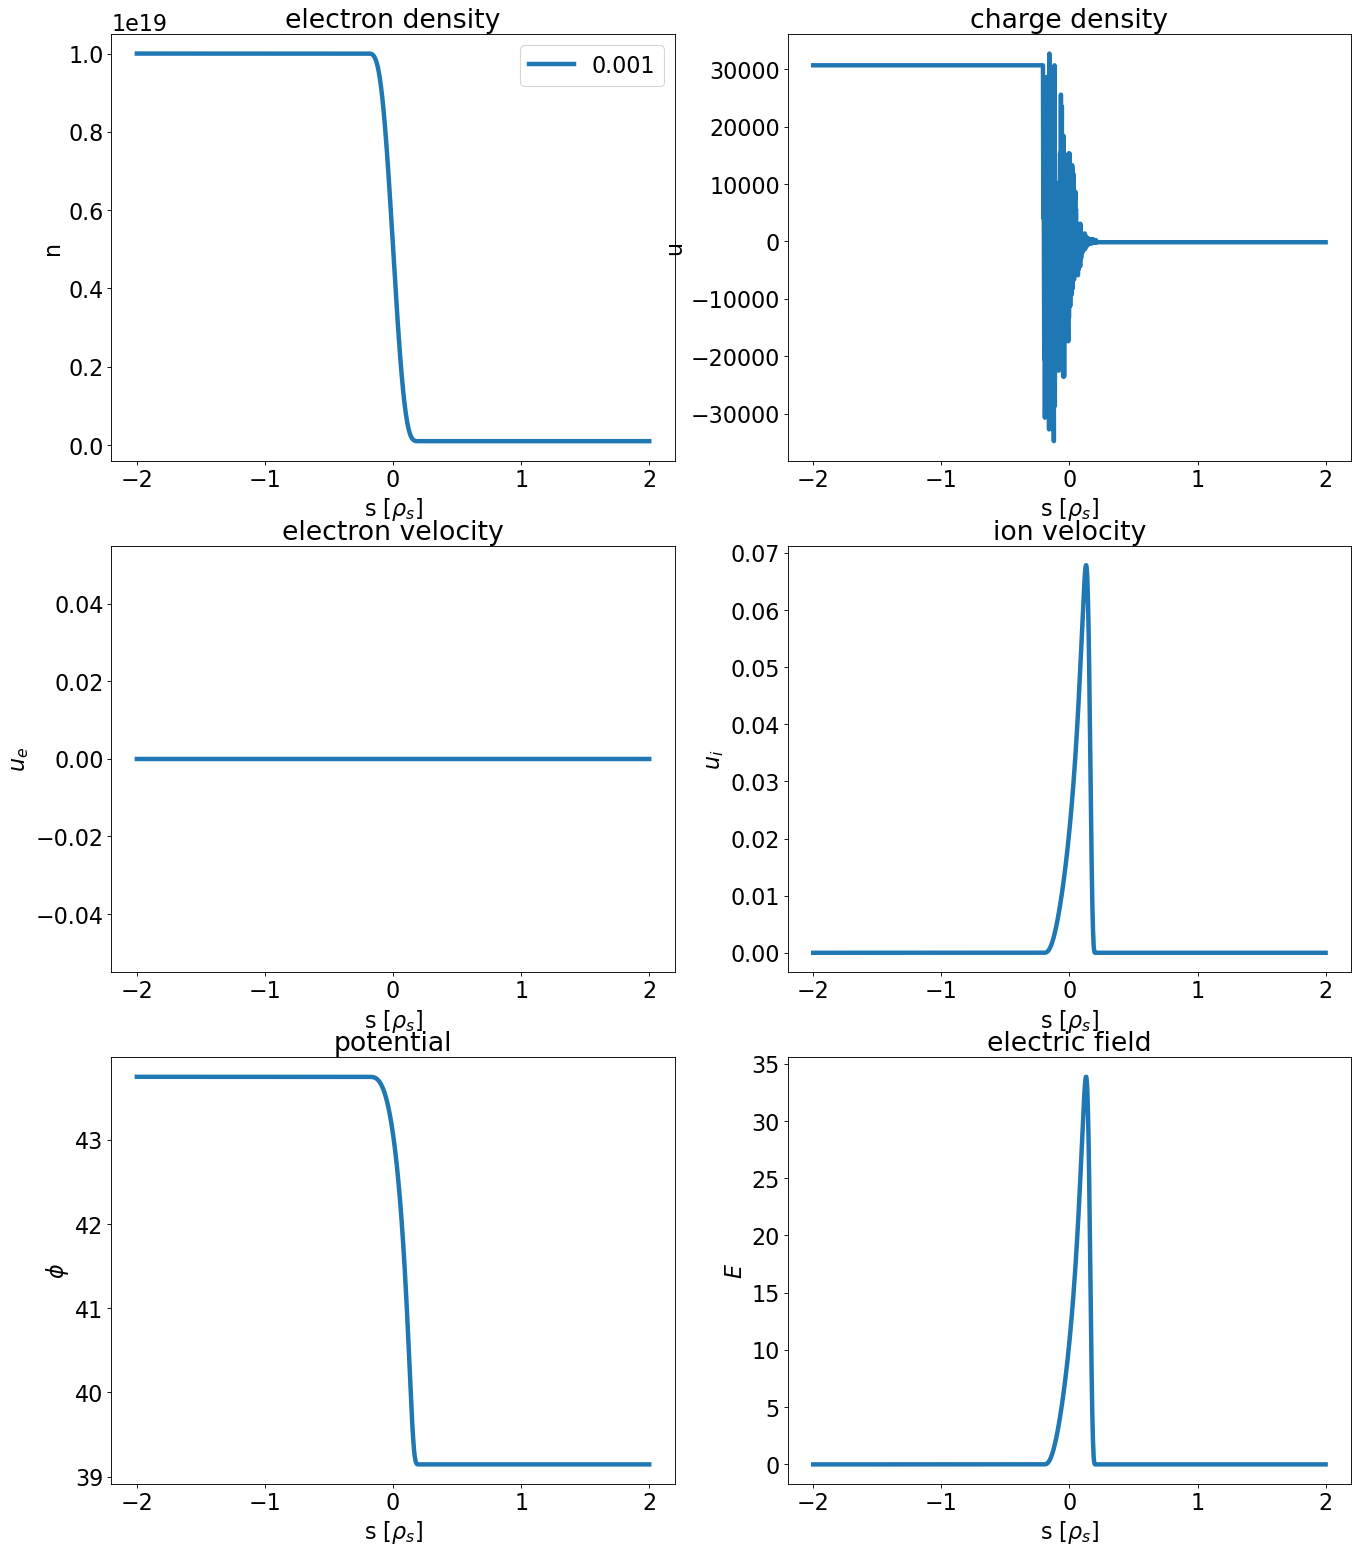

In [9]:
# Let us try adiabatic electrons
p_list = []
for p in [
     {"type" : "staggered", "variant" : "original"},
    #{"type" : "staggered", "variant" : "slope-limiter"},
#     {"type" : "staggered", "variant" : "explicit"},
    #{"type" : "staggered", "variant" : "slope-limiter-explicit"},
#     {"type" : "centered"},
         ] :
        
    params = make_plasma_input(table)
    params["physical"]["type"] = "adiabatic"
    
    params["init"]["type"]="soft-step"
   
    params["init"]["x_a"]=0   # location of jump (in units of lx)
    params["init"]["n_l"]=1e19    #density left of jump
    params["init"]["n_r"]=1e17  # density right of jump
    
 
    params["grid"]["Nx"]= 1600
    params["output"]["tend"] =1e-3 #1e-4 to 1e-2
    params["timestepper"]["type"] = "ARK"
    params["timestepper"]["tableau"]  = "ARK-4-2-3"
    params["poisson"]["eps"]= 1e-12
    params["poisson"]["type"] = "anderson"
    #params["poisson"]["damping"] = 1e-1
    
    params["physical"]["mu"] = -1
    params["physical"]["nu_u"] = [0.,0.]
    params["physical"]["tau"] =1.
   
    params["physical"]["resistivity"] = 0.0
    params["advection"] = p
    params["timestepper"]["rtol"] = 1e-5
    params["grid"]["x"]=[-2,2]
    
    p_list.append(params)
plot_plasma(p_list)
print(params)